# Rekko challenge 2019

```
                           /$$$$$$$  /$$$$$$$$ /$$   /$$ /$$   /$$  /$$$$$$ 
                          | $$__  $$| $$_____/| $$  /$$/| $$  /$$/ /$$__  $$
                          | $$  \ $$| $$      | $$ /$$/ | $$ /$$/ | $$  \ $$
                          | $$$$$$$/| $$$$$   | $$$$$/  | $$$$$/  | $$  | $$
                          | $$__  $$| $$__/   | $$  $$  | $$  $$  | $$  | $$
                          | $$  \ $$| $$      | $$\  $$ | $$\  $$ | $$  | $$
                          | $$  | $$| $$$$$$$$| $$ \  $$| $$ \  $$|  $$$$$$/
                          |__/  |__/|________/|__/  \__/|__/  \__/ \______/ 
                                                                            
```

Добро пожаловать на соревнование по машинному обучению от онлайн-кинотеатра [Okko](http://okko.tv) Rekko Challenge 2019.

В этом ноутбуке мы покажем вам пример простого но полного решения, от загрузки данных до формирования ответа. Для работы нам понадобятся библиотеки `pandas`, `numpy`, `scipy`, `implicit`, `pprint`, `tqdm`. Установить их в вашем рабочем окружении можно следующей командой.
```
pip install pandas numpy scipy implicit pprint tqdm
```

In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp
import seaborn as sns
import matplotlib as plt 
%matplotlib inline

from pprint import pprint

### Загрузка данных

Замените `DATA_PATH` на путь к данным, которые вы скачали со страницы соревнования.

In [2]:
DATA_PATH = './data'

---

`catalogue.json` содержит анонимизированную метаинформацию о доступных в сервисе фильмах и сериалах.

In [3]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)

type(catalogue)
catalogue = {int(k): v for k, v in catalogue.items()}

In [4]:
len(catalogue)

10200

In [5]:
pprint(catalogue[0])

{'attributes': [31115, 6713, 10906, 31116, 31117, 270, 24431, 42, 31118, 31119],
 'availability': [],
 'duration': 80,
 'feature_1': 29121982.214158818,
 'feature_2': 0.5752595062,
 'feature_3': 0,
 'feature_4': 1.1283323575,
 'feature_5': 0.6547073468,
 'type': 'movie'}


#### Превращаем каталог в DataFrame

In [6]:
df_catalogue = pd.DataFrame.from_dict(catalogue, orient='index')

In [7]:
df_catalogue.head()

,type,availability,duration,feature_1,feature_2,feature_3,feature_4,feature_5,attributes
0,movie,[],80,2.912198e+07,0.575260,0,1.128332,0.654707,"[31115, 6713, 10906, 31116, 31117, 270, 24431,..."
1,movie,"[purchase, rent]",120,6.610431e+06,0.773224,3,1.112014,0.654707,"[2786, 385, 2799, 3730, 886, 7, 11700, 42, 20,..."
2,movie,[],80,1.315874e+07,0.699502,0,1.110127,0.680410,"[31442, 31443, 31444, 31445, 113, 31446, 42, 3..."
3,series,[],20,4.157712e+07,0.702981,0,1.141929,0.654707,"[34361, 34362, 23033, 14887, 270, 20089, 43, 25]"
4,movie,"[purchase, rent, subscription]",70,3.999579e+07,0.626596,8,1.130076,0.592716,"[26732, 26733, 26734, 9367, 7792, 336, 26735, ..."


In [8]:
df_catalogue.describe()
df_catalogue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10200 entries, 0 to 10199
Data columns (total 9 columns):
type            10200 non-null object
availability    10200 non-null object
duration        10200 non-null int64
feature_1       10200 non-null float64
feature_2       10200 non-null float64
feature_3       10200 non-null int64
feature_4       10200 non-null float64
feature_5       10200 non-null float64
attributes      10200 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 796.9+ KB


 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1..5` — пять анонимизированных вещественных и порядковых признаков
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

---

`test_users.json` содержит список пользователей, для которых необходимо построить предсказание

In [9]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

---

`transactions.csv` — список всех транзакций за определённый период времени

In [10]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

Wall time: 7.28 s


In [11]:
transactions.head(3)

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50


#### Подтянем к транзакциям сведения о фильме

In [12]:
transactions = pd.merge(transactions, df_catalogue, how='left', left_on='element_uid', right_index=True)

 - `element_uid` — идентификатор элемента
 - `user_uid` — идентификатор пользователя
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке)
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке
 - `watched_time` — число просмотренных по транзакции секунд
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр

In [13]:
transactions.describe()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer,duration,feature_1,feature_2,feature_3,feature_4,feature_5
count,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06
mean,4.903627e+03,2.972156e+05,4.308295e+07,6.338216e+03,7.113436e-01,5.378050e+01,9.295729e+01,3.009230e+07,7.278252e-01,1.964941e+01,1.130437e+00,5.248951e-01
std,2.962026e+03,1.710970e+05,7.459096e+05,1.823438e+04,1.523222e+00,3.064894e+01,3.181568e+01,1.342369e+07,5.150818e-02,1.081772e+01,2.107137e-02,2.958060e-01
min,0.000000e+00,0.000000e+00,4.173063e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.006248e+02,2.658995e-01,0.000000e+00,7.343941e-01,-1.000000e+00
25%,2.332000e+03,1.489950e+05,4.243755e+07,9.780000e+02,0.000000e+00,5.000000e+01,8.000000e+01,1.900747e+07,6.980000e-01,1.200000e+01,1.130076e+00,5.927161e-01
50%,4.661000e+03,2.973630e+05,4.314893e+07,4.959000e+03,0.000000e+00,5.000000e+01,1.000000e+02,3.633499e+07,7.360206e-01,1.700000e+01,1.138604e+00,6.547073e-01
75%,7.433000e+03,4.453270e+05,4.372865e+07,6.446000e+03,0.000000e+00,9.000000e+01,1.100000e+02,4.129727e+07,7.662538e-01,2.600000e+01,1.140273e+00,6.547073e-01
max,1.019900e+04,5.934890e+05,4.430518e+07,4.326296e+06,6.000000e+00,9.900000e+01,2.900000e+02,4.380675e+07,8.270144e-01,5.000000e+01,1.141929e+00,6.804097e-01


#### Проставляем флаг того, что клиент потребил фильм

In [14]:
element_agg = transactions.groupby('element_uid').agg({'watched_time': ['mean', 'median']})
element_agg.columns = ['elem_watched_time_mean', 'elem_watched_time_median']
transactions = pd.merge(transactions, element_agg, how='left', left_on='element_uid', right_index=True)

In [136]:
transactions.groupby(['element_uid', 'type', 'duration', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',\
                     ])['user_uid'].count().sort_values(ascending=False)

element_uid  type    duration  feature_1     feature_2  feature_3  feature_4  feature_5
2714         movie   130       4.234673e+07  0.740500   45         1.141929    0.592716    68320
747          movie   120       4.195494e+07  0.773630   44         1.140273    0.449667    61272
2639         movie   140       4.079335e+07  0.764594   47         1.140273    0.654707    61119
3783         movie   110       3.556521e+07  0.766254   41         1.138604    0.654707    55228
2245         movie   110       4.097526e+07  0.784022   45         1.140273    0.449667    52942
6127         movie   130       4.146583e+07  0.726889   29         1.141929    0.680410    52168
10061        movie   100       4.156312e+07  0.664360   26         1.141929    0.654707    48993
3916         movie   130       3.715533e+07  0.702486   17         1.140273    0.592716    48243
8771         series  50        4.161910e+07  0.786378   2          1.138604    0.654707    47480
3336         movie   90        4.166108

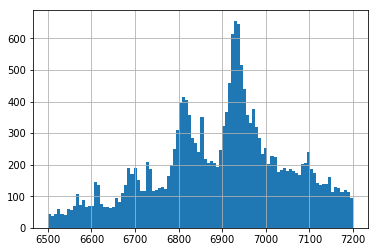

In [184]:
transactions[(transactions['element_uid']==2639)&(transactions['watched_time']<7200)&(transactions['watched_time']>6500)]['watched_time'].hist(bins=100)

In [171]:
top_count = pd.DataFrame(transactions.groupby(['element_uid'])['user_uid'].count().sort_values(ascending=False)).reset_index()

In [173]:
top_count.columns = ['element_uid', 'count']

In [176]:
top_count.head(3)

,element_uid,count
0,2714,68320
1,747,61272
2,2639,61119


In [153]:
ratings = pd.merge(ratings, df_catalogue, how='left', left_on='element_uid', right_index=True)

In [177]:
ratings = pd.merge(ratings, top_count, how='left', on='element_uid')

In [181]:
ratings[ratings['count']>10000].groupby(['element_uid', 'type', 'duration', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',\
                     'count'])['rating'].mean().sort_values(ascending=False)

element_uid  type    duration  feature_1     feature_2  feature_3  feature_4  feature_5  count  
6606         series  20        3.225516e+07  0.812768   14         1.131807   0.592716   17239.0    9.527174
2257         series  50        3.770105e+07  0.819963   23         1.130076   0.680410   25843.0    9.509132
7513         movie   110       1.746133e+07  0.813131   40         1.130076   0.654707   11616.0    9.449477
3502         series  50        4.123701e+07  0.782443   14         1.138604   0.680410   13597.0    9.406593
8771         series  50        4.161910e+07  0.786378   2          1.138604   0.654707   47480.0    9.346698
3567         movie   100       4.069541e+07  0.807276   42         1.140273   0.592716   42278.0    9.202940
3137         movie   130       3.570366e+07  0.778864   31         1.138604   0.680410   21617.0    9.159848
1364         movie   130       1.671216e+06  0.795648   40         1.115741   0.592716   13504.0    9.135945
5541         movie   90        

In [16]:
targets = transactions.query(""" consumption_mode == 'P' or consumption_mode == 'R' \
    or consumption_mode == 'S' and type in ['series', 'multipart_movie'] and watched_time > elem_watched_time_median /3 \
    or consumption_mode == 'S' and type == 'movie' and watched_time / 60 > duration / 2 """)
targets.describe()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer,duration,feature_1,feature_2,feature_3,feature_4,feature_5,elem_watched_time_mean,elem_watched_time_median
count,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06,6.558159e+06
mean,4.915903e+03,2.970374e+05,4.307423e+07,8.973787e+03,6.273113e-01,5.331692e+01,9.356283e+01,3.047970e+07,7.286954e-01,2.000053e+01,1.130690e+00,5.294272e-01,6.586072e+03,5.410154e+03
std,2.957592e+03,1.710971e+05,7.434018e+05,2.160543e+04,1.429497e+00,3.025051e+01,3.227748e+01,1.348188e+07,5.042258e-02,1.096756e+01,2.152439e-02,2.859834e-01,7.985530e+03,2.936313e+03
min,0.000000e+00,0.000000e+00,4.173063e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.006248e+02,2.658995e-01,0.000000e+00,7.343941e-01,-1.000000e+00,0.000000e+00,0.000000e+00
25%,2.360500e+03,1.487140e+05,4.242619e+07,4.892000e+03,0.000000e+00,5.000000e+01,8.000000e+01,1.942723e+07,6.985012e-01,1.200000e+01,1.130076e+00,5.927161e-01,3.969532e+03,4.490000e+03
50%,4.681000e+03,2.971780e+05,4.313255e+07,5.853000e+03,0.000000e+00,5.000000e+01,1.000000e+02,3.715533e+07,7.360206e-01,1.800000e+01,1.138604e+00,6.547073e-01,4.980626e+03,5.426000e+03
75%,7.433000e+03,4.450980e+05,4.371430e+07,7.294000e+03,0.000000e+00,8.500000e+01,1.100000e+02,4.146583e+07,7.662538e-01,2.700000e+01,1.140273e+00,6.547073e-01,6.307795e+03,6.295000e+03
max,1.019900e+04,5.934890e+05,4.430518e+07,4.326296e+06,6.000000e+00,9.900000e+01,2.900000e+02,4.380675e+07,8.270144e-01,5.000000e+01,1.141929e+00,6.804097e-01,1.712741e+05,9.651250e+04


In [83]:
targets.shape

(6558159, 18)

---

`ratings.csv` содержит информацию о поставленных пользователями оценках

In [151]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

Wall time: 267 ms


In [140]:
ratings.head(3)

,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07


 - `rating` — поставленный пользователем рейтинг (от `0` до `10`)

---

In [19]:
ratings.describe()

,user_uid,element_uid,rating,ts
count,438790.000000,438790.000000,438790.000000,4.387900e+05
mean,297633.918918,4877.467467,8.189079,4.298166e+07
std,170411.749934,2952.994260,2.074550,7.275682e+05
min,1.000000,3.000000,0.000000,4.173065e+07
25%,147598.000000,2297.000000,7.000000,4.232747e+07
50%,300425.000000,4709.000000,9.000000,4.301707e+07
75%,445190.000000,7381.000000,10.000000,4.358960e+07
max,593486.000000,10199.000000,10.000000,4.430517e+07


`bookmarks.csv` содержит информацию об элементах, добавленных пользователями в список «Избранное»

In [20]:
%%time
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

Wall time: 494 ms


In [21]:
bookmarks.head(3)

,user_uid,element_uid,ts
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07


### Решение

Для начала построим список элементов, которые тестовые пользователи уже купили или посмотрели по подписке: они не смогут купить их второй раз, а просмотр по подписке второй раз маловероятен, поэтому мы захотим отфильтровать такие элементы из финального ответа.

Точно так же можно поступить и с рейтингами и добавлениями в избранное, если это будет казаться правильным.

---

#### Построим разреженную матрицу по транзакциям и обучимся только на "старых" данных

In [102]:
%%time

validation_percent = 1

ts_cut_off = targets['ts'].quantile(validation_percent)

train_transactions = pd.DataFrame(targets.query('ts < @ts_cut_off +0.01'))
train_transactions['user_uid'] = train_transactions['user_uid'].astype('category')
train_transactions['element_uid'] = train_transactions['element_uid'].astype('category')
train_transactions['has_trans_flg'] = 1

validation_transactions = transactions.query('ts >= @ts_cut_off')
validation_users = set(validation_transactions['user_uid'])
validation_result = {k: g["element_uid"].tolist() for k,g in validation_transactions.groupby("user_uid")}

transactions_matrix = sp.coo_matrix(
    (train_transactions['has_trans_flg'].astype(np.float32) + 1,
        (
            train_transactions['element_uid'].cat.codes.copy(),
            train_transactions['user_uid'].cat.codes.copy()
        )
    )
)

transactions_matrix = transactions_matrix.tocsr()

Wall time: 3.17 s


In [108]:
train_transactions.shape

(6558159, 19)

In [85]:
sparsity = transactions_matrix.nnz / (transactions_matrix.shape[0] * transactions_matrix.shape[1])
print('Sparsity: %.6f' % sparsity)

Sparsity: 0.001635


Обучить модель крайне просто.

In [86]:
from implicit.nearest_neighbours import TFIDFRecommender

model = TFIDFRecommender()
model.fit(transactions_matrix)

100%|████████████████████████████████████████████████████████████████████████████| 8221/8221 [00:00<00:00, 8368.52it/s]


---

In [87]:
transactions_matrix_T = transactions_matrix.T.tocsr()

Отображения из оригинальной категории во внутреннюю пригодится нам в дальнейшем.

In [88]:
user_uid_to_cat = dict(zip(
    train_transactions['user_uid'].cat.categories,
    range(len(train_transactions['user_uid'].cat.categories))
))

In [89]:
element_uid_to_cat = dict(zip(
    train_transactions['element_uid'].cat.categories,
    range(len(train_transactions['element_uid'].cat.categories))
))

#### Отфильтруем ненужные элементы

In [109]:
from collections import defaultdict

filtered_elements = defaultdict(set)

for user_uid, element_uid in tqdm.tqdm(transactions.loc[:, ['user_uid', 'element_uid']].values):
    if user_uid not in test_users:
        continue
    filtered_elements[user_uid].add(element_uid)

100%|████████████████████████████████████████████████████████████████████| 9643012/9643012 [00:18<00:00, 531456.08it/s]


In [112]:
len(filtered_elements_cat)

49992

In [113]:
filtered_elements_cat = {k: [element_uid_to_cat.get(x, None) for x in v] for k, v in filtered_elements.items()}

---

В метод `model.recommend` мы передаём идентификатор пользователя, который получаем обратным преобразованием из категории, транспонированную матрицу взаимодействий, число необходимых рекомендаций и список элементов, которые мы договорились фильтровать из ответа.

Возвращает метод список пар (`element_cat`, `score`), отсортированный по вторым элементам. Из него необходимо достать все первые элементы пар и из категории преобразовать их к `element_uid`.

**Если необходимо построить предсказание для тестовой выборки, нужно заменить validation_users на test_users.**

NB. Не забыть поменять сплит train'a и валидационной выборки

In [114]:
result = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = user_uid_to_cat[user_uid]
    except LookupError:
        continue
    
    # perform inference
    recs = model.recommend(
        user_cat,
        transactions_matrix_T,
        N=20,
        filter_already_liked_items=True,
        filter_items=filtered_elements_cat.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    result[user_uid] = [int(train_transactions['element_uid'].cat.categories[i]) for i, _ in recs]

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:17<00:00, 2929.51it/s]


In [93]:
len(result)

49669

#### Построили предсказание для валидационной выборки. Посмотрим на качество на этой выборке.

Расчет метрики сохранен в файле metric.pyx. Это код на Cython, поэтому нужно подключение отдельных библиотек и компиляция этого файла. 

In [80]:
import time
import pyximport; pyximport.install()
import metric

print("Final metric on validation = %.5f" % metric.metric(validation_result, result))

Final metric on validation = 0.01685


#### Дамп ответа в json

In [116]:
from datetime import datetime

with open('submits/transactions-' + datetime.now().strftime('%Y-%m-%d %H-%M-%S') + '.json', 'w') as f:
    json.dump(result, f)